In [1]:
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
from pycocotools.coco import COCO

import os
import json
import numpy as np
import cv2
import random
from skimage import measure
import pandas as pd
from itertools import groupby
import itertools
from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from pathlib import Path
from PIL import Image
import warnings
warnings.simplefilter(action='ignore')

### Preprocess the Folders 

sample scan path = case2/case2_day1/scans/slice_0001_266_266_1.50_1.50.png 

sample case in train.csv = case123_day20_slice_0001	 

In [2]:
pwd

'/Users/srikaranreddy/Desktop/Spring Semester/Computer Vision 6.8300/cv-project/gi-tract-image-segmentation/notebooks'

In [3]:
project_base_dir = "../uw-madison-gi-tract-image-segmentation"
data_train_dir = os.path.join(project_base_dir, 'train')


def get_scan_file_path(base_dir, scan_id):
    """
    Helper function to derive the 
    full file path for a given scan ID
    """
    id_parts = scan_id.split("_")
    case_part = id_parts[0]
    day_part = "_".join(id_parts[:2])
    scan_prefix = "_".join(id_parts[2:])
    scan_directory = os.path.join(base_dir, case_part, day_part, "scans")
    matching_files = glob(f"{scan_directory}/{scan_prefix}*")  # Expecting a single match
    return matching_files[0]

# Load the dataset and prepare for processing
data_csv_file = os.path.join(project_base_dir, "train.csv")
dataset = pd.read_csv(data_csv_file)
dataset['case_number'] = dataset['id'].apply(lambda id_str: id_str.split('_')[0][4:])
dataset['day_number'] = dataset['id'].apply(lambda id_str: id_str.split('_')[1][3:])
dataset['slice_number'] = dataset['id'].apply(lambda id_str: id_str.split('_')[-1])
dataset['file_path'] = dataset['id'].apply(lambda id_str: get_scan_file_path(data_train_dir, id_str))

# Derive filename and other attributes from the file path
dataset['file_name'] = dataset['file_path'].apply(lambda path: os.path.basename(path))
dataset['composite_id'] = dataset.apply(lambda row: f"{row['case_number']}_{row['day_number']}_{row['file_name']}", axis=1)

# Extract image dimensions directly from the filename components
dataset['image_height'] = dataset['file_name'].apply(lambda name: int(name.split('_')[2]))
dataset['image_width'] = dataset['file_name'].apply(lambda name: int(name.split('_')[3]))
dataset['resolution'] = dataset.apply(lambda row: f"{row['image_height']}x{row['image_width']}", axis=1)

# Output a sample of the dataset for review
dataset.sample(5)

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
31027,case117_day17_slice_0023,small_bowel,23874 6 24149 8 24424 10 24699 12 24975 13 252...,117,17,0023,../uw-madison-gi-tract-image-segmentation/trai...,slice_0023_276_276_1.63_1.63.png,117_17_slice_0023_276_276_1.63_1.63.png,276,276,276x276
13822,case15_day0_slice_0144,small_bowel,NaN,15,0,0144,../uw-madison-gi-tract-image-segmentation/trai...,slice_0144_266_266_1.50_1.50.png,15_0_slice_0144_266_266_1.50_1.50.png,266,266,266x266
7877,case130_day0_slice_0034,stomach,38742 8 39004 14 39268 18 39526 26 39791 28 40...,130,0,0034,../uw-madison-gi-tract-image-segmentation/trai...,slice_0034_266_266_1.50_1.50.png,130_0_slice_0034_266_266_1.50_1.50.png,266,266,266x266
18165,case66_day36_slice_0072,large_bowel,13971 7 14232 24 14495 29 14753 38 15017 40 15...,66,36,0072,../uw-madison-gi-tract-image-segmentation/trai...,slice_0072_266_266_1.50_1.50.png,66_36_slice_0072_266_266_1.50_1.50.png,266,266,266x266
112376,case2_day4_slice_0115,stomach,NaN,2,4,0115,../uw-madison-gi-tract-image-segmentation/trai...,slice_0115_266_266_1.50_1.50.png,2_4_slice_0115_266_266_1.50_1.50.png,266,266,266x266


In [4]:
dataset.shape

(115488, 12)

In [5]:
dataset.dtypes

id              object
class           object
segmentation    object
case_number     object
day_number      object
slice_number    object
file_path       object
file_name       object
composite_id    object
image_height     int64
image_width      int64
resolution      object
dtype: object

In [6]:
dataset.isna().mean(axis=0) # 70% of segmentation are null 

id              0.00000
class           0.00000
segmentation    0.70635
case_number     0.00000
day_number      0.00000
slice_number    0.00000
file_path       0.00000
file_name       0.00000
composite_id    0.00000
image_height    0.00000
image_width     0.00000
resolution      0.00000
dtype: float64

In [7]:
dataset[dataset['segmentation'].isnull()].shape

(81575, 12)

In [8]:
dataset[dataset['segmentation'].notnull()].shape

(33913, 12)

### Filtering the dataset with non null values of segmentation

In [9]:
masked_dataset = dataset[dataset['segmentation'].notnull()]
masked_dataset["segmentation"] = dataset["segmentation"].astype("str")
masked_dataset = masked_dataset.reset_index(drop=True)
masked_dataset.head()

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,../uw-madison-gi-tract-image-segmentation/trai...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,266x266
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,../uw-madison-gi-tract-image-segmentation/trai...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,266x266
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,../uw-madison-gi-tract-image-segmentation/trai...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,266x266
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,../uw-madison-gi-tract-image-segmentation/trai...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,266x266
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,../uw-madison-gi-tract-image-segmentation/trai...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,266x266


Text(0.5, 1.0, 'Partition based on case')

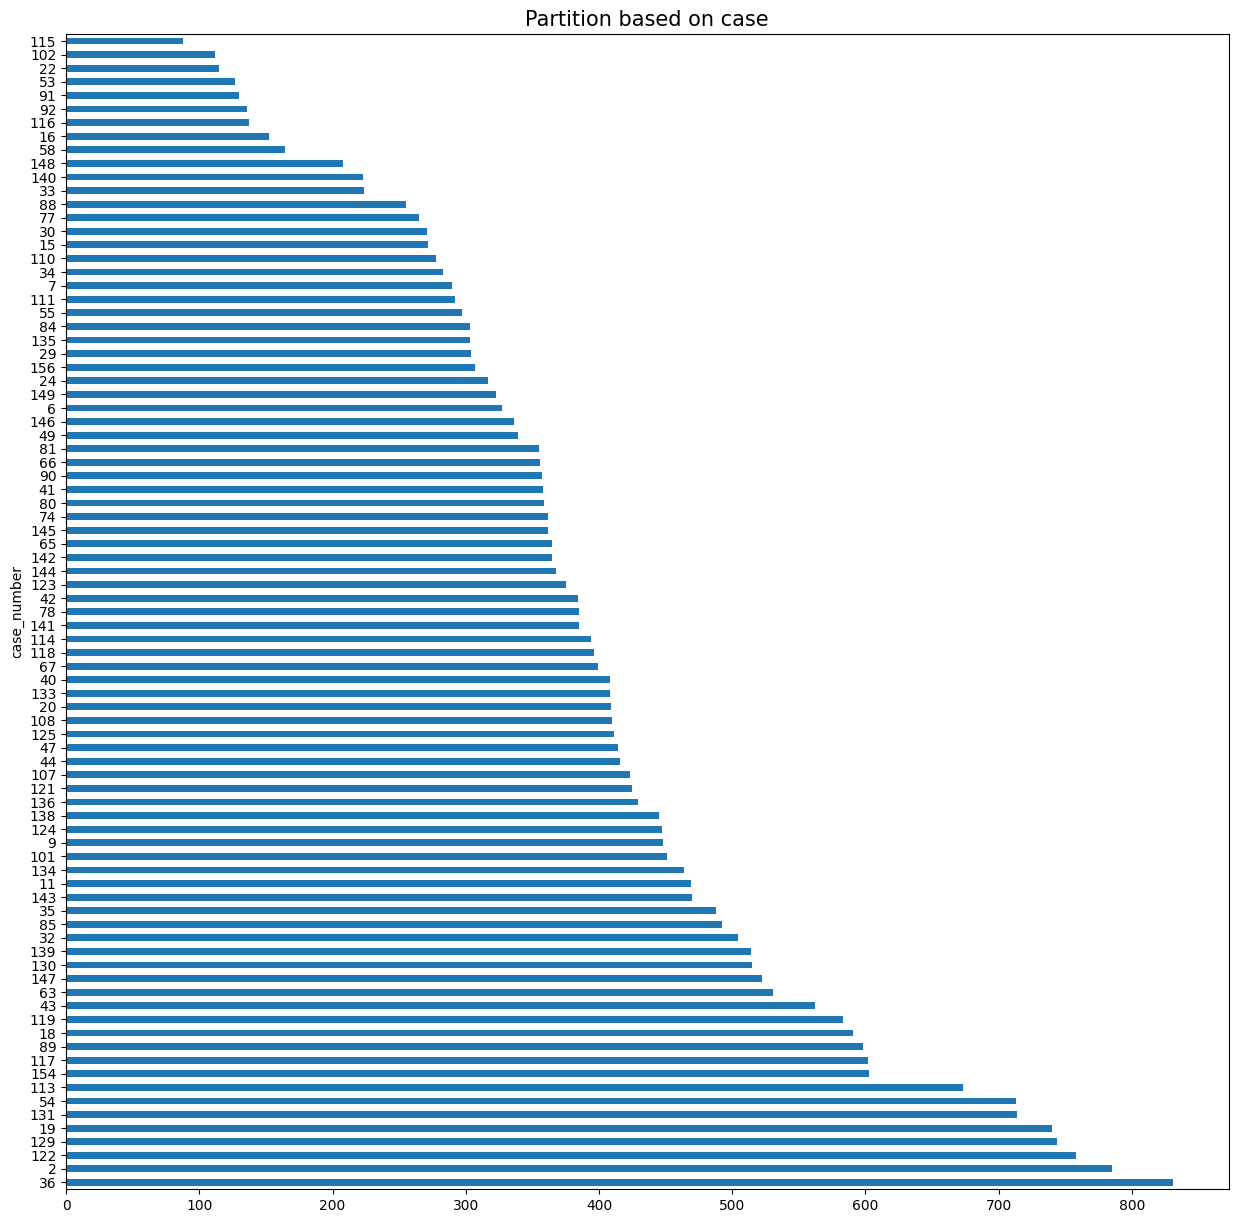

In [10]:
fig = plt.figure(figsize=(15, 15))
masked_dataset['case_number'].value_counts().plot(kind='barh')
plt.title('Partition based on case', fontsize=15)

Text(0.5, 1.0, 'Partition based on day')

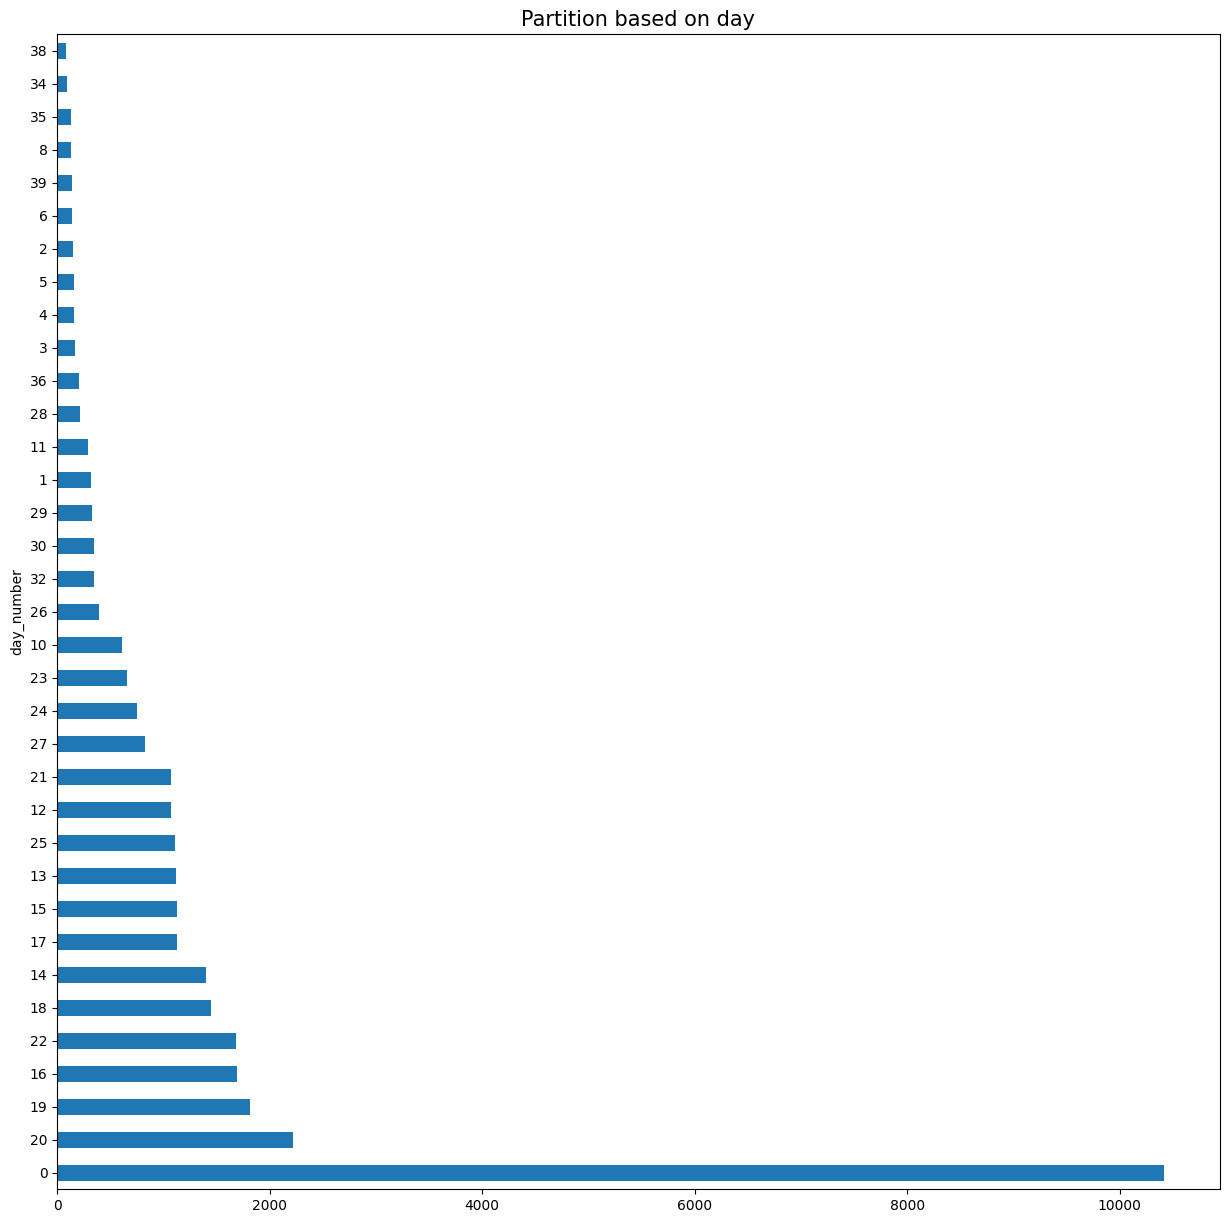

In [11]:
fig = plt.figure(figsize=(15, 15))
masked_dataset['day_number'].value_counts().plot(kind='barh')
plt.title('Partition based on day' , fontsize=15)

In [12]:
pd.options.display.max_colwidth = 200
masked_dataset.file_path.head(1)[0]

'../uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png'

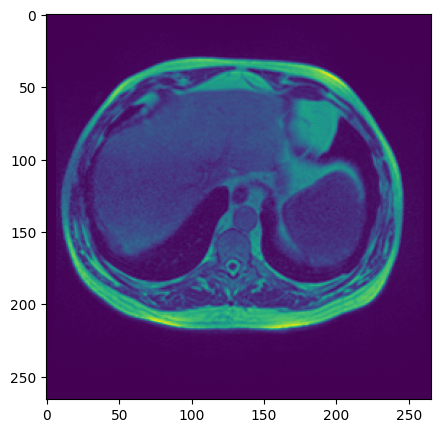

In [13]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(5, 5))
img = mpimg.imread(masked_dataset.file_path[0])
imgplot = plt.imshow(img)
plt.show()

In [14]:
masked_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
 3   case_number   33913 non-null  object
 4   day_number    33913 non-null  object
 5   slice_number  33913 non-null  object
 6   file_path     33913 non-null  object
 7   file_name     33913 non-null  object
 8   composite_id  33913 non-null  object
 9   image_height  33913 non-null  int64 
 10  image_width   33913 non-null  int64 
 11  resolution    33913 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.1+ MB


<Axes: >

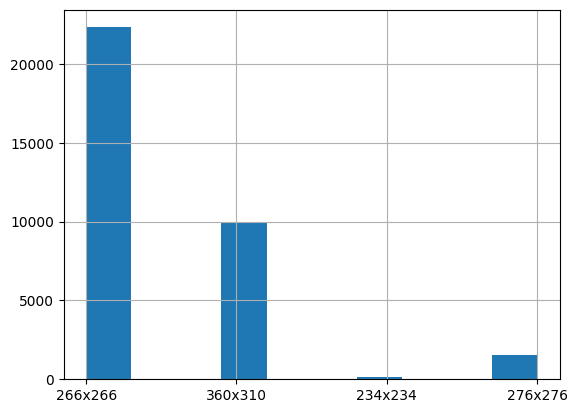

In [15]:
masked_dataset['resolution'].hist()

<Axes: >

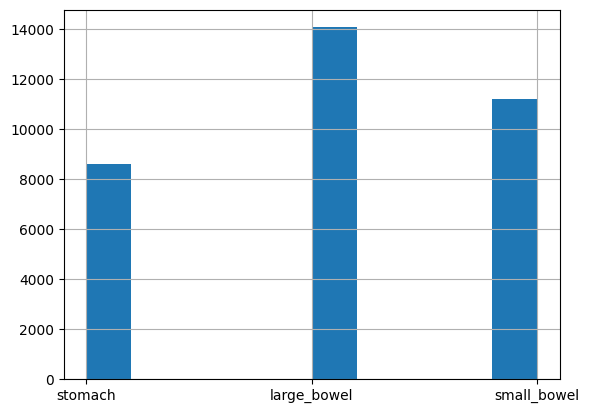

In [16]:
masked_dataset['class'].hist()

<Axes: xlabel='case_number'>

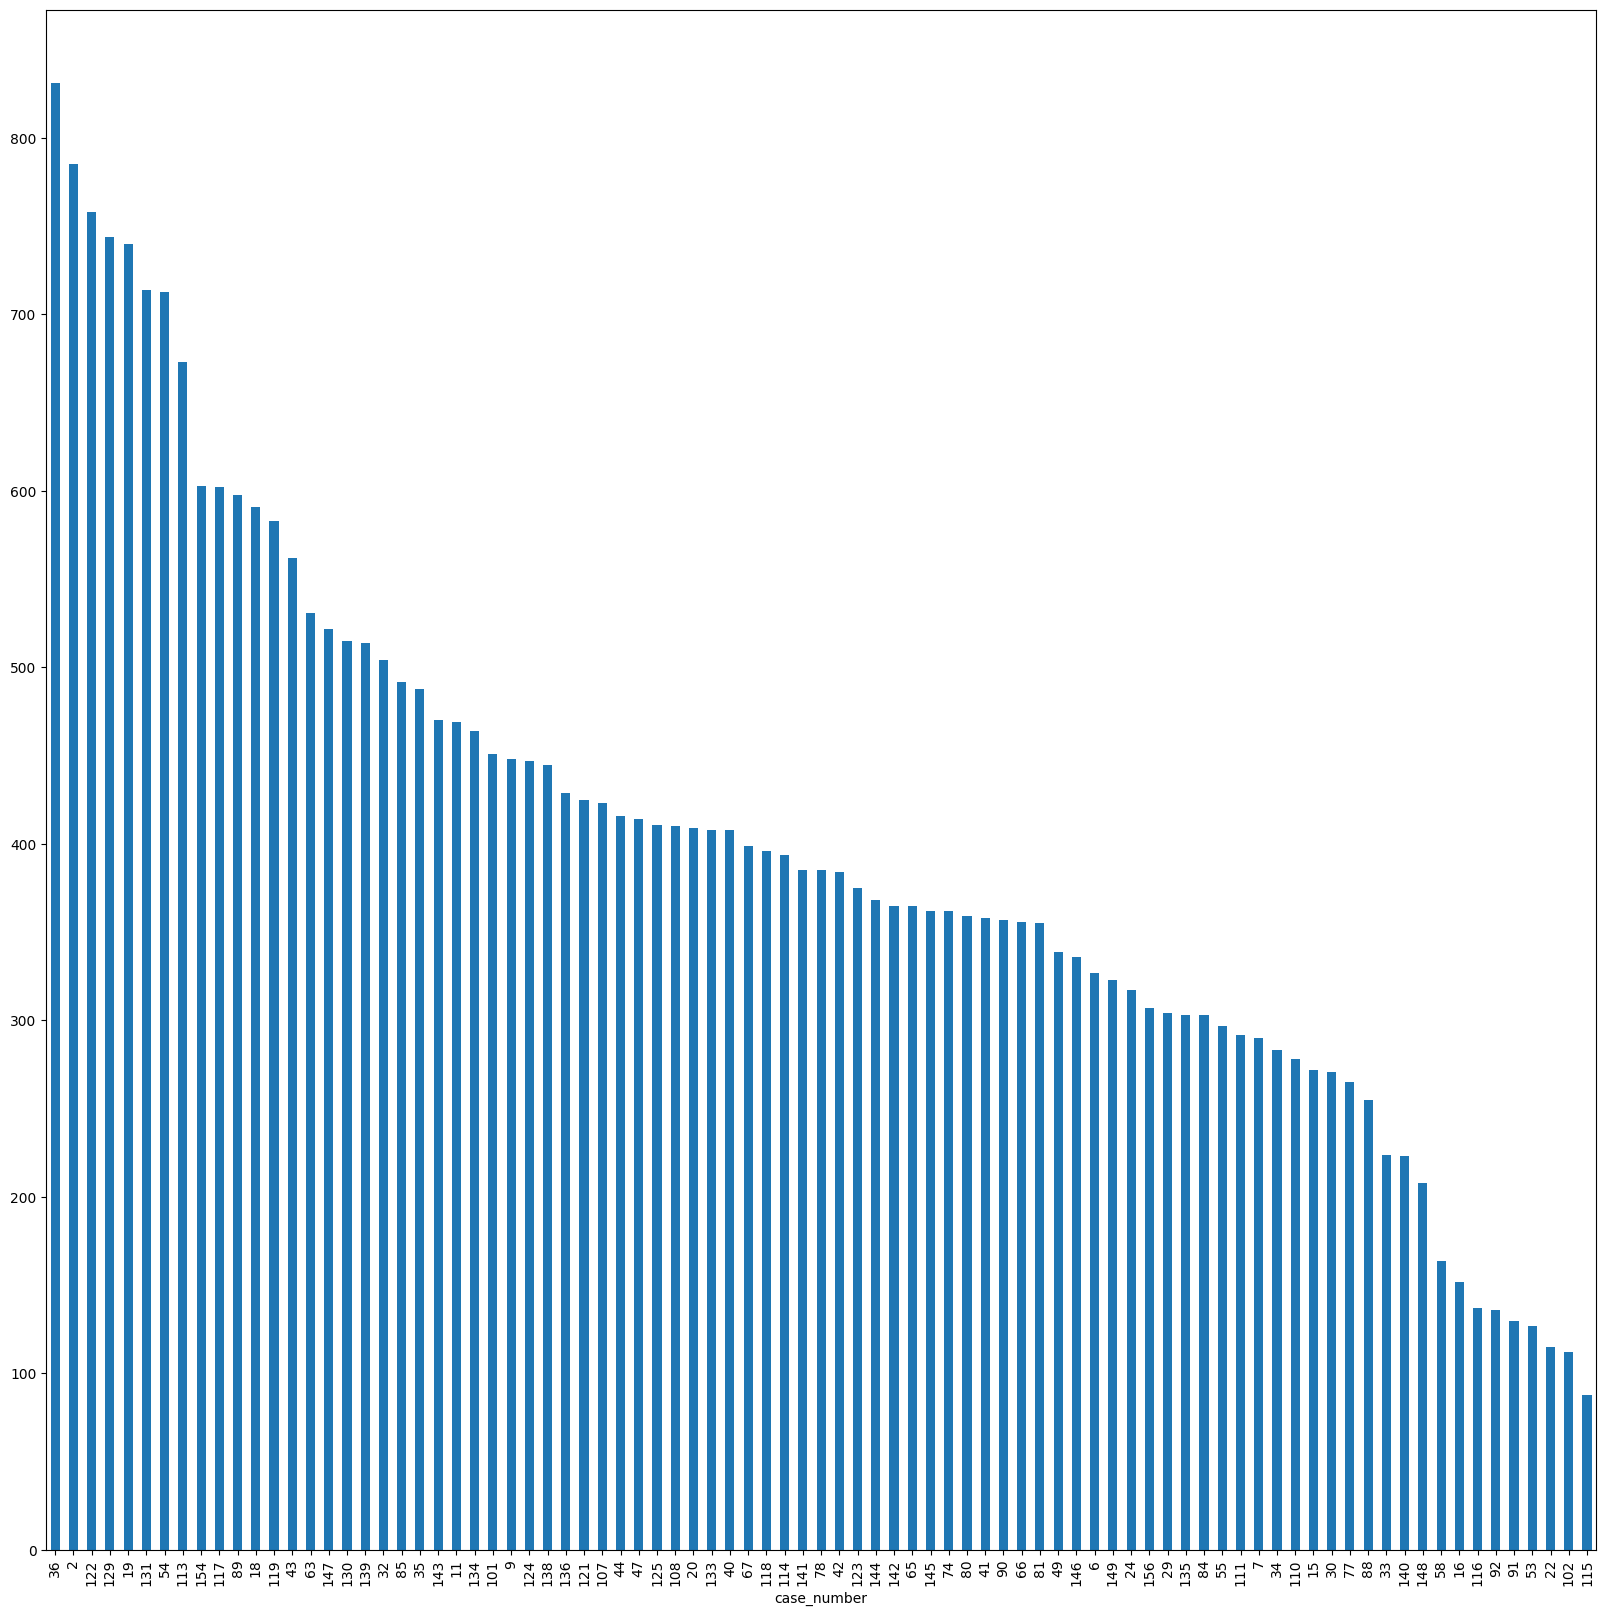

In [17]:
fig = plt.figure(figsize=(20, 20))
masked_dataset['case_number'].value_counts().plot(kind='bar')

(<Figure size 640x480 with 3 Axes>,
 {('stomach', '266x266'): (0.0, 0.0, 0.2518675480911698, 0.6651922871665862),
  ('stomach', '360x310'): (0.0,
   0.6684926171995894,
   0.2518675480911698,
   0.27337612629931124),
  ('stomach', '234x234'): (0.0,
   0.945169073531904,
   0.2518675480911698,
   0.005508838817114611),
  ('stomach', '276x276'): (0.0,
   0.9539782423820219,
   0.2518675480911698,
   0.04602175761797808),
  ('large_bowel', '266x266'): (0.25681804314067475,
   0.0,
   0.41121530252279204,
   0.6450932633199422),
  ('large_bowel', '360x310'): (0.25681804314067475,
   0.6483935933529454,
   0.41121530252279204,
   0.29579954800591884),
  ('large_bowel', '234x234'): (0.25681804314067475,
   0.9474934713918677,
   0.41121530252279204,
   0.0023197207899703057),
  ('large_bowel', '276x276'): (0.25681804314067475,
   0.9531135222148412,
   0.41121530252279204,
   0.04688647778515874),
  ('small_bowel', '266x266'): (0.6729838407129718,
   0.0,
   0.3270161592870282,
   0.65013643

<Figure size 4000x4000 with 0 Axes>

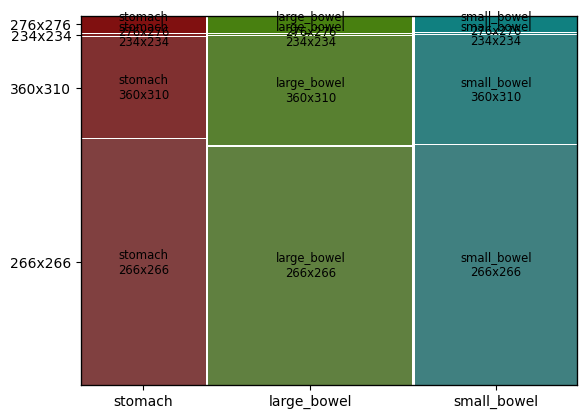

In [18]:
from statsmodels.graphics.mosaicplot import mosaic

plt.figure(figsize=(40, 40))
plt.rcParams['font.size'] = 10.0
mosaic(masked_dataset, ['class', 'resolution'], )


In [27]:
masked_dataset['case_number'].value_counts()

case_number
36     831
2      785
122    758
129    744
19     740
      ... 
91     130
53     127
22     115
102    112
115     88
Name: count, Length: 85, dtype: int64

In [30]:
masked_dataset = masked_dataset[(masked_dataset['case_number']=='7') | (masked_dataset['day_number']=='0')]

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
243,case123_day0_slice_0049,stomach,30755 5 31020 7 31285 9 31550 10 31815 11 32080 12 32345 13 32611 13 32876 14 33142 14 33408 14 33674 13 33940 13 34206 13 34472 12 34738 11 35004 10 35270 9 35538 6,123,0,0049,../uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0049_266_266_1.50_1.50.png,slice_0049_266_266_1.50_1.50.png,123_0_slice_0049_266_266_1.50_1.50.png,266,266,266x266
244,case123_day0_slice_0050,stomach,29157 5 29421 8 29685 11 29950 13 30215 15 30481 17 30746 18 31011 20 31277 20 31543 20 31809 20 32075 20 32340 21 32605 22 32871 22 33137 22 33403 22 33669 22 33935 22 34201 22 34467 21 34733 21 ...,123,0,0050,../uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0050_266_266_1.50_1.50.png,slice_0050_266_266_1.50_1.50.png,123_0_slice_0050_266_266_1.50_1.50.png,266,266,266x266
245,case123_day0_slice_0051,stomach,28358 8 28623 10 28887 13 29152 15 29417 16 29682 18 29947 20 30213 21 30478 22 30744 23 31010 23 31276 23 31541 25 31807 25 32072 26 32338 26 32603 27 32869 27 33135 27 33401 27 33666 28 33932 28...,123,0,0051,../uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0051_266_266_1.50_1.50.png,slice_0051_266_266_1.50_1.50.png,123_0_slice_0051_266_266_1.50_1.50.png,266,266,266x266
246,case123_day0_slice_0052,stomach,26764 9 27028 11 27292 14 27557 15 27823 15 28088 16 28354 16 28619 18 28884 19 29149 21 29415 22 29680 23 29946 24 30211 25 30477 26 30743 26 31008 27 31274 28 31540 28 31805 29 32070 30 32336 30...,123,0,0052,../uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0052_266_266_1.50_1.50.png,slice_0052_266_266_1.50_1.50.png,123_0_slice_0052_266_266_1.50_1.50.png,266,266,266x266
247,case123_day0_slice_0053,stomach,25169 4 25433 8 25698 11 25963 13 26228 15 26493 16 26758 18 27024 18 27290 18 27556 18 27821 19 28087 19 28352 21 28617 22 28883 23 29148 24 29414 25 29679 27 29945 27 30211 27 30476 29 30742 29 ...,123,0,0053,../uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0053_266_266_1.50_1.50.png,slice_0053_266_266_1.50_1.50.png,123_0_slice_0053_266_266_1.50_1.50.png,266,266,266x266
...,...,...,...,...,...,...,...,...,...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 23866 13 24132 14 24397 17 24663 18 24928 21 25193 24 25459 25 25724 27 25989 30 26254 32 26519 35 26784 37 27050 38 27315 40 27564 59 27829 61 28094 63 2...,30,0,0135,../uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0135_266_266_1.50_1.50.png,slice_0135_266_266_1.50_1.50.png,30_0_slice_0135_266_266_1.50_1.50.png,266,266,266x266
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 19801 58 20063 64 20324 71 20586 79 20849 85 21112 89 21376 91 21640 94 21905 96 22170 97 22435 99 22700 100 22966 100 23231 102 23496 102 23761 103 2402...,30,0,0136,../uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0136_266_266_1.50_1.50.png,slice_0136_266_266_1.50_1.50.png,30_0_slice_0136_266_266_1.50_1.50.png,266,266,266x266
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 24405 14 24671 15 24936 17 25201 18 25465 21 25730 23 25995 25 26254 32 26518 35 26783 37 27049 38 27296 6 27314 39 27561 9 27577 43 27827 13 27842 44 280...,30,0,0136,../uw-madison-gi-tract-image-segmentation/train/case30/case30_day0/scans/slice_0136_266_266_1.50_1.50.png,slice_0136_266_266_1.50_1.50.png,30_0_slice_0136_266_266_1.50_1.50.png,266,266,266x266
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 19539 44 19803 48 20066 54 20328 59 20588 65 20850 69 21113 73 21377 75 21641 77 21905 79 22170 80 22435 82 22700 83 22965 84 23230 85 23495 86 23759 88 2...,30,0,0137,../uw-madison-gi-tract-image-segmentation/train/case30/c

In [31]:
masked_dataset.to_csv('madison.csv')

In [32]:
# case where same image has both the classes 

pd.options.display.max_colwidth = 50
masked_dataset[masked_dataset['id'] == 'case121_day0_slice_0107']

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
26418,case121_day0_slice_0107,large_bowel,16886 6 17148 13 17410 19 17673 30 17936 37 18...,121,0,0107,../uw-madison-gi-tract-image-segmentation/trai...,slice_0107_266_266_1.50_1.50.png,121_0_slice_0107_266_266_1.50_1.50.png,266,266,266x266
26419,case121_day0_slice_0107,small_bowel,21709 4 21972 11 22238 16 22503 21 22769 23 23...,121,0,0107,../uw-madison-gi-tract-image-segmentation/trai...,slice_0107_266_266_1.50_1.50.png,121_0_slice_0107_266_266_1.50_1.50.png,266,266,266x266


In [33]:
masked_dataset.segmentation[0]

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

In [34]:
masked_dataset.resolution[0]

'266x266'

In [40]:
dataset.head()

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../uw-madison-gi-tract-image-segmentation/trai...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,266x266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../uw-madison-gi-tract-image-segmentation/trai...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,266x266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../uw-madison-gi-tract-image-segmentation/trai...,slice_0001_266_266_1.50_1.50.png,123_20_slice_0001_266_266_1.50_1.50.png,266,266,266x266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../uw-madison-gi-tract-image-segmentation/trai...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,266x266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../uw-madison-gi-tract-image-segmentation/trai...,slice_0002_266_266_1.50_1.50.png,123_20_slice_0002_266_266_1.50_1.50.png,266,266,266x266


In [74]:
from torchvision.transforms import CenterCrop
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader, random_split
import glob

class SegmentationDataset(Dataset):
    def __init__(self, base_dir, csv_path, resize_shape):
        self.train_csv = pd.read_csv(csv_path)
        self.resize_shape = resize_shape
        self.processed_df = self.preprocess(self.train_csv)
        self.scans = sorted(glob.glob(base_dir + '/**/*.png', recursive=True))

        # self.files_with_nones = [self.retrieve_masks(idx) for idx in range(len(self.scans))]
        # self.files = [i for i in self.files_with_nones if i]

    def preprocess(self, df):
        df['segmentation'] = df.segmentation.fillna('')
        df['length'] = df.segmentation.map(len)
        df2 = df.groupby('id')['segmentation'].agg(list).to_frame().reset_index()
        df2 = df2.merge(df.groupby('id')['length'].agg(sum).to_frame().reset_index())
        df2.drop(df2[df2.length == 0].index, inplace=True) #16590 
        df2['missing'] = df2.segmentation.map(lambda x : True if '' in x else False)
        df2.drop(df2[df2.missing == True].index, inplace=True)
        return df2  
        

In [83]:
scans = sorted(glob.glob('../datasets/train/' + '**/*.png', recursive=True))

In [84]:
scans[0]

'../datasets/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [86]:
idx = 0
bits = scans[idx].split('/')
mask_id = '_'.join([bits[-3]] + bits[-1].split('_')[:2])
print(bits, mask_id)
if mask_id in sd.preprocess['id'].to_list():
    masks_row = self.preprocess.loc[self.preprocess['id'] == mask_id]['segmentation'].item()
    large_bowel_str, small_bowel_str, stomach_str = masks_row
    return  {'scan':self.scans[idx],
                     'stomach' : stomach_str,
                     'small_bowel': small_bowel_str,
                     'large_bowel': large_bowel_str}

['..', 'datasets', 'train', 'case101', 'case101_day20', 'scans', 'slice_0001_266_266_1.50_1.50.png'] case101_day20_slice_0001


SyntaxError: 'return' outside function (2473393094.py, line 8)

In [51]:
ls ../

config.py                               requirements.txt
data/                                   src/
notebooks/                              uw-madison-gi-tract-image-segmentation/


In [ ]:
sd = SegmentationDataset(

In [55]:
dataset['segmentation'].notnull().sum()

33913

In [56]:
df = pd.read_csv('../uw-madison-gi-tract-image-segmentation/train.csv')
df.shape

(115488, 3)

In [57]:
df['segmentation'] = df.segmentation.fillna('')
df['length'] = df.segmentation.map(len)
df.head()

,id,class,segmentation,length
0,case123_day20_slice_0001,large_bowel,,0
1,case123_day20_slice_0001,small_bowel,,0
2,case123_day20_slice_0001,stomach,,0
3,case123_day20_slice_0002,large_bowel,,0
4,case123_day20_slice_0002,small_bowel,,0


In [61]:
df2 = df.groupby('id')['segmentation'].agg(list).to_frame().reset_index()
df2 = df2.merge(df.groupby('id')['length'].agg(sum).to_frame().reset_index())
df2.drop(df2[df2.length == 0].index, inplace=True)
df2

,id,segmentation,length
65,case101_day20_slice_0066,"[, , 32107 5 32371 10 32635 13 32900 15 33165 ...",239
66,case101_day20_slice_0067,"[, , 31313 2 31577 7 31841 10 32105 14 32369 1...",275
67,case101_day20_slice_0068,"[, , 30517 2 30781 6 31046 9 31311 11 31575 15...",311
68,case101_day20_slice_0069,"[, , 29981 10 30246 13 30511 16 30776 19 31041...",350
69,case101_day20_slice_0070,"[, , 28918 9 29182 14 29446 18 29711 21 29976 ...",402
...,...,...,...
38466,case9_day22_slice_0115,[38022 2 38380 7 38739 9 39099 10 39295 6 3945...,2158
38467,case9_day22_slice_0116,[38021 4 38379 8 38739 10 38938 2 39099 10 392...,2129
38468,case9_day22_slice_0117,[38020 7 38379 10 38738 12 38936 4 39098 12 39...,1974
38469,case9_day22_slice_0118,[37661 5 38019 10 38378 12 38738 12 39097 14 3...,1992


In [63]:
df2['missing'] = df2.segmentation.map(lambda x : True if '' in x else False)
df2.drop(df2[df2.missing == True].index, inplace=True)

In [72]:
df2.segmentation.values[0]

['24687 4 24950 10 25215 13 25480 15 25745 17 26010 19 26276 20 26541 22 26806 23 27072 24 27337 25 27603 25 27869 25 28135 25 28401 24 28667 24 28933 24 29199 23 29466 22 29733 20 30001 16 30269 12 31081 9 31343 15 31607 18 31873 19 32138 20 32404 20 32670 20 32936 20 33202 20 33468 20 33735 19 34001 18 34268 17 34534 16 34801 15 35068 13 35162 7 35335 12 35427 9 35602 10 35692 11 35869 8 35958 12 36137 4 36223 14 36489 15 36755 16 37021 16 37287 16 37552 17 37817 18 38083 18 38348 18 38614 18 38879 19 39145 19 39411 19 39677 19 39943 18 40209 18 40475 17 40741 17 41007 16 41274 15 41540 14 41807 13 42074 11 42342 7',
 '25662 3 25927 5 26192 6 26458 10 26723 12 26989 12 27254 13 27520 12 27785 12 28051 11 28317 10 28583 9 28849 8 29116 6',
 '18772 25 19036 32 19301 36 19566 40 19831 43 20096 45 20361 48 20625 51 20890 53 21155 55 21420 57 21685 58 21949 61 22214 62 22479 64 22744 65 23009 67 23274 68 23539 69 23804 71 24070 71 24336 71 24601 72 24867 72 25133 72 25400 71 25666 71 2593

In [76]:
sd = SegmentationDataset(base_dir='../datasets',
                         csv_path='../datasets/train.csv',
                         resize_shape=(128, 128))

In [77]:
sd.scans

['../datasets/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0002_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0003_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0004_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0006_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0007_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0008_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0009_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0010_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0011_266_266_1.50_1.50.png',
 '../datasets/train/case101/case101_day20/scans/slice_0012_266_266_1.50_1.50.png',
 '..

In [37]:
# Creation of train test split
train_df, test_df = train_test_split(masked_dataset, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


print("Number of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))

Number of Train Images:27130
Number of Test Images:6783


In [38]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

### Run Length Encoding

Example: 28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6

- Create a flat image with 0s and then append the rle values as a mask
- Then re-shape the flat image to original dimensions to get the actual mask

In [35]:
def decode_rle(mask_rle, shape):
    '''
    Decode an RLE-encoded mask into a 2D numpy array.

    Parameters:
        mask_rle (str): Run-length encoding of the mask ('start length' pairs)
        shape (tuple): The (height, width) dimensions of the output array

    Returns:
        numpy.ndarray: A 2D array where 1s represent the mask and 0s represent the background
    '''
    # Split the RLE string into a list of strings
    encoded_pixels = mask_rle.split()
    
    # Extract start positions and lengths for the mask
    starts = np.asarray(encoded_pixels[0::2], dtype=int) - 1  # Convert to 0-based indexing
    lengths = np.asarray(encoded_pixels[1::2], dtype=int)
    
    # Calculate the end positions for each segment of the mask
    ends = starts + lengths
    
    # Initialize a flat array for the image
    flat_image = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Apply the mask to the flat image array
    for start, end in zip(starts, ends):
        flat_image[start:end] = 1
    
    # Reshape the flat image array to 2D
    return flat_image.reshape(shape)



In [36]:
def convert_binary_mask_to_rle(binary_mask):
    '''
    Convert a binary mask to run-length encoding.

    Parameters:
        binary_mask (numpy.ndarray): A 2D array where 1s represent the mask and 0s the background.

    Returns:
        dict: A dictionary with two keys: 'counts' and 'size', where 'counts' holds the RLE and 'size' the dimensions of the mask.
    '''
    # Initialize the RLE dictionary with the size of the mask
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    
    # Prepare to fill the counts list in the RLE dictionary
    counts = rle['counts']
    
    # Flatten the array column-wise and group by value
    flattened = binary_mask.ravel(order='F')
    grouped = itertools.groupby(flattened)
    
    # Iterate through grouped data to form the RLE
    for i, (pixel_value, group_iter) in enumerate(grouped):
        # Convert group iterator to list to count elements
        group_length = len(list(group_iter))
        
        # If first group is mask, prepend 0
        if i == 0 and pixel_value == 1:
            counts.append(0)
        
        # Append the length of each group to the RLE counts
        counts.append(group_length)
    
    return rle

In [29]:
import cv2
import numpy as np
from tqdm import tqdm

def create_coco_categories(classes):
    """ Create categories section for COCO JSON. """
    categories = [{"id": idx, "name": cls} for idx, cls in enumerate(classes)]
    return categories

def decode_segmentation_and_generate_annotations(data_frame, image_id, filepath, classes):
    """ Decode segmentation data and prepare annotations for a single image. """
    annotations = []
    file_id = ('_'.join(
        (filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
    height_slice = int(filepath.split("/")[-1].split("_")[3])
    width_slice = int(filepath.split("/")[-1].split("_")[2])

    ids = data_frame.index[data_frame['id'] == file_id].tolist()
    if len(ids) > 0:
        for idx in ids:
            segmentation_mask = decode_rle(
                data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
            for contour in cv2.findContours(segmentation_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)[0]:
                mask_image = np.zeros(segmentation_mask.shape, dtype=np.uint8)
                cv2.drawContours(mask_image, [contour], -1, 255, -1)
                encoded_segmentation = convert_binary_mask_to_rle(mask_image)
                ys, xs = np.where(mask_image)
                x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
                annotations.append({
                    'segmentation': encoded_segmentation,
                    'bbox': [x1, y1, x2 - x1 + 1, y2 - y1 + 1],  # (x, y, w, h) format
                    'area': mask_image.sum(),
                    'image_id': image_id,
                    'category_id': classes.index(data_frame.iloc[idx]['class']),
                    'iscrowd': 0,
                    'id': len(annotations)
                })
    return annotations

def create_coco_images(filepaths):
    """ Create images section for COCO JSON. """
    images = []
    for i, filepath in enumerate(tqdm(filepaths, desc="Processing images")):
        file_name = '/'.join(filepath.split("/")[3:])
        height = int(filepath.split("/")[-1].split("_")[3])
        width = int(filepath.split("/")[-1].split("_")[2])
        images.append({
            "id": i + 1,
            "file_name": file_name,
            "width": width,
            "height": height
        })
    return images

def create_coco_format_json(data_frame, classes, filepaths):
    """ Main function to create COCO formatted JSON. """
    categories = create_coco_categories(classes)
    images = create_coco_images(filepaths)
    annotations = []
    count = 0
    
    for image in tqdm(images, desc="Generating annotations"):
        image_id = image['id']
        filepath = image['file_name']
        
        file_id = ('_'.join(
            (filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
    
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        if len(ids) > 0:
            for idx in ids:
                segmentation_mask = decode_rle(
                    data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                for contour in cv2.findContours(segmentation_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)[0]:
                    mask_image = np.zeros(segmentation_mask.shape, dtype=np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, 255, -1)
                    encoded_segmentation = convert_binary_mask_to_rle(mask_image)
                    ys, xs = np.where(mask_image)
                    x1, y1, x2, y2 = min(xs), min(ys), max(xs), max(ys)
                    annotations.append({
                        'segmentation': encoded_segmentation,
                        'bbox': [x1, y1, x2 - x1 + 1, y2 - y1 + 1],  # (x, y, w, h) format
                        'area': mask_image.sum(),
                        'image_id': image_id,
                        'category_id': classes.index(data_frame.iloc[idx]['class']),
                        'iscrowd': 0,
                        'id': count
                    })
                    count += 1
        
    return {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }

In [30]:
# Creation of train test split
train_df, test_df = train_test_split(masked_dataset, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


print("Number of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))

Number of Train Images:27130
Number of Test Images:6783


In [31]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [32]:
indexes = test_df['id'].value_counts().sort_values(ascending=False).to_frame().iloc[:1000, :].index

In [33]:
tmp_df = test_df[test_df['id'].isin(indexes)].sample(16)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.sort_values(['composite_id']).sample(4)


,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
1,case77_day18_slice_0122,large_bowel,20101 12 20362 20 20626 26 20889 31 21151 38 2...,77,18,0122,../uw-madison-gi-tract-image-segmentation/trai...,slice_0122_266_266_1.50_1.50.png,77_18_slice_0122_266_266_1.50_1.50.png,266,266,266x266
0,case35_day12_slice_0073,small_bowel,27491 5 27765 8 28040 10 28287 7 28314 12 2856...,35,12,0073,../uw-madison-gi-tract-image-segmentation/trai...,slice_0073_276_276_1.63_1.63.png,35_12_slice_0073_276_276_1.63_1.63.png,276,276,276x276
7,case130_day0_slice_0088,large_bowel,29625 11 29889 15 29929 22 30152 19 30190 30 3...,130,0,0088,../uw-madison-gi-tract-image-segmentation/trai...,slice_0088_266_266_1.50_1.50.png,130_0_slice_0088_266_266_1.50_1.50.png,266,266,266x266
11,case118_day16_slice_0095,small_bowel,12618 6 12881 16 13146 20 13172 5 13409 27 134...,118,16,0095,../uw-madison-gi-tract-image-segmentation/trai...,slice_0095_266_266_1.50_1.50.png,118_16_slice_0095_266_266_1.50_1.50.png,266,266,266x266


In [34]:
classes = ['small_bowel', 'large_bowel', 'stomach']
tmp_json = create_coco_format_json(tmp_df, classes, tmp_df['file_path'].tolist())

tmp_json

Generating annotations: 100%|███████████████████| 16/16 [00:00<00:00, 39.07it/s]


{'categories': [{'id': 0, 'name': 'small_bowel'},
  {'id': 1, 'name': 'large_bowel'},
  {'id': 2, 'name': 'stomach'}],
 'images': [{'id': 1,
   'file_name': 'case35/case35_day12/scans/slice_0073_276_276_1.63_1.63.png',
   'width': 276,
   'height': 276},
  {'id': 2,
   'file_name': 'case77/case77_day18/scans/slice_0122_266_266_1.50_1.50.png',
   'width': 266,
   'height': 266},
  {'id': 3,
   'file_name': 'case118/case118_day0/scans/slice_0053_276_276_1.63_1.63.png',
   'width': 276,
   'height': 276},
  {'id': 4,
   'file_name': 'case129/case129_day0/scans/slice_0081_360_310_1.50_1.50.png',
   'width': 360,
   'height': 310},
  {'id': 5,
   'file_name': 'case147/case147_day14/scans/slice_0079_266_266_1.50_1.50.png',
   'width': 266,
   'height': 266},
  {'id': 6,
   'file_name': 'case11/case11_day13/scans/slice_0090_360_310_1.50_1.50.png',
   'width': 360,
   'height': 310},
  {'id': 7,
   'file_name': 'case24/case24_day25/scans/slice_0072_266_266_1.50_1.50.png',
   'width': 266,
   '

In [35]:
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()


with open('./tmp_json.json', 'w', encoding='utf-8') as f:
    json.dump(tmp_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [36]:
from pathlib import Path
annFile = Path(f'./tmp_json.json')

In [37]:
coco = COCO(annFile)
coco

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [38]:
imgIds = coco.getImgIds()
imgIds

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [39]:
pwd

'/Users/srikaranreddy/Desktop/Spring Semester/Computer Vision 6.8300/cv-project/gi-tract-image-segmentation/notebooks'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


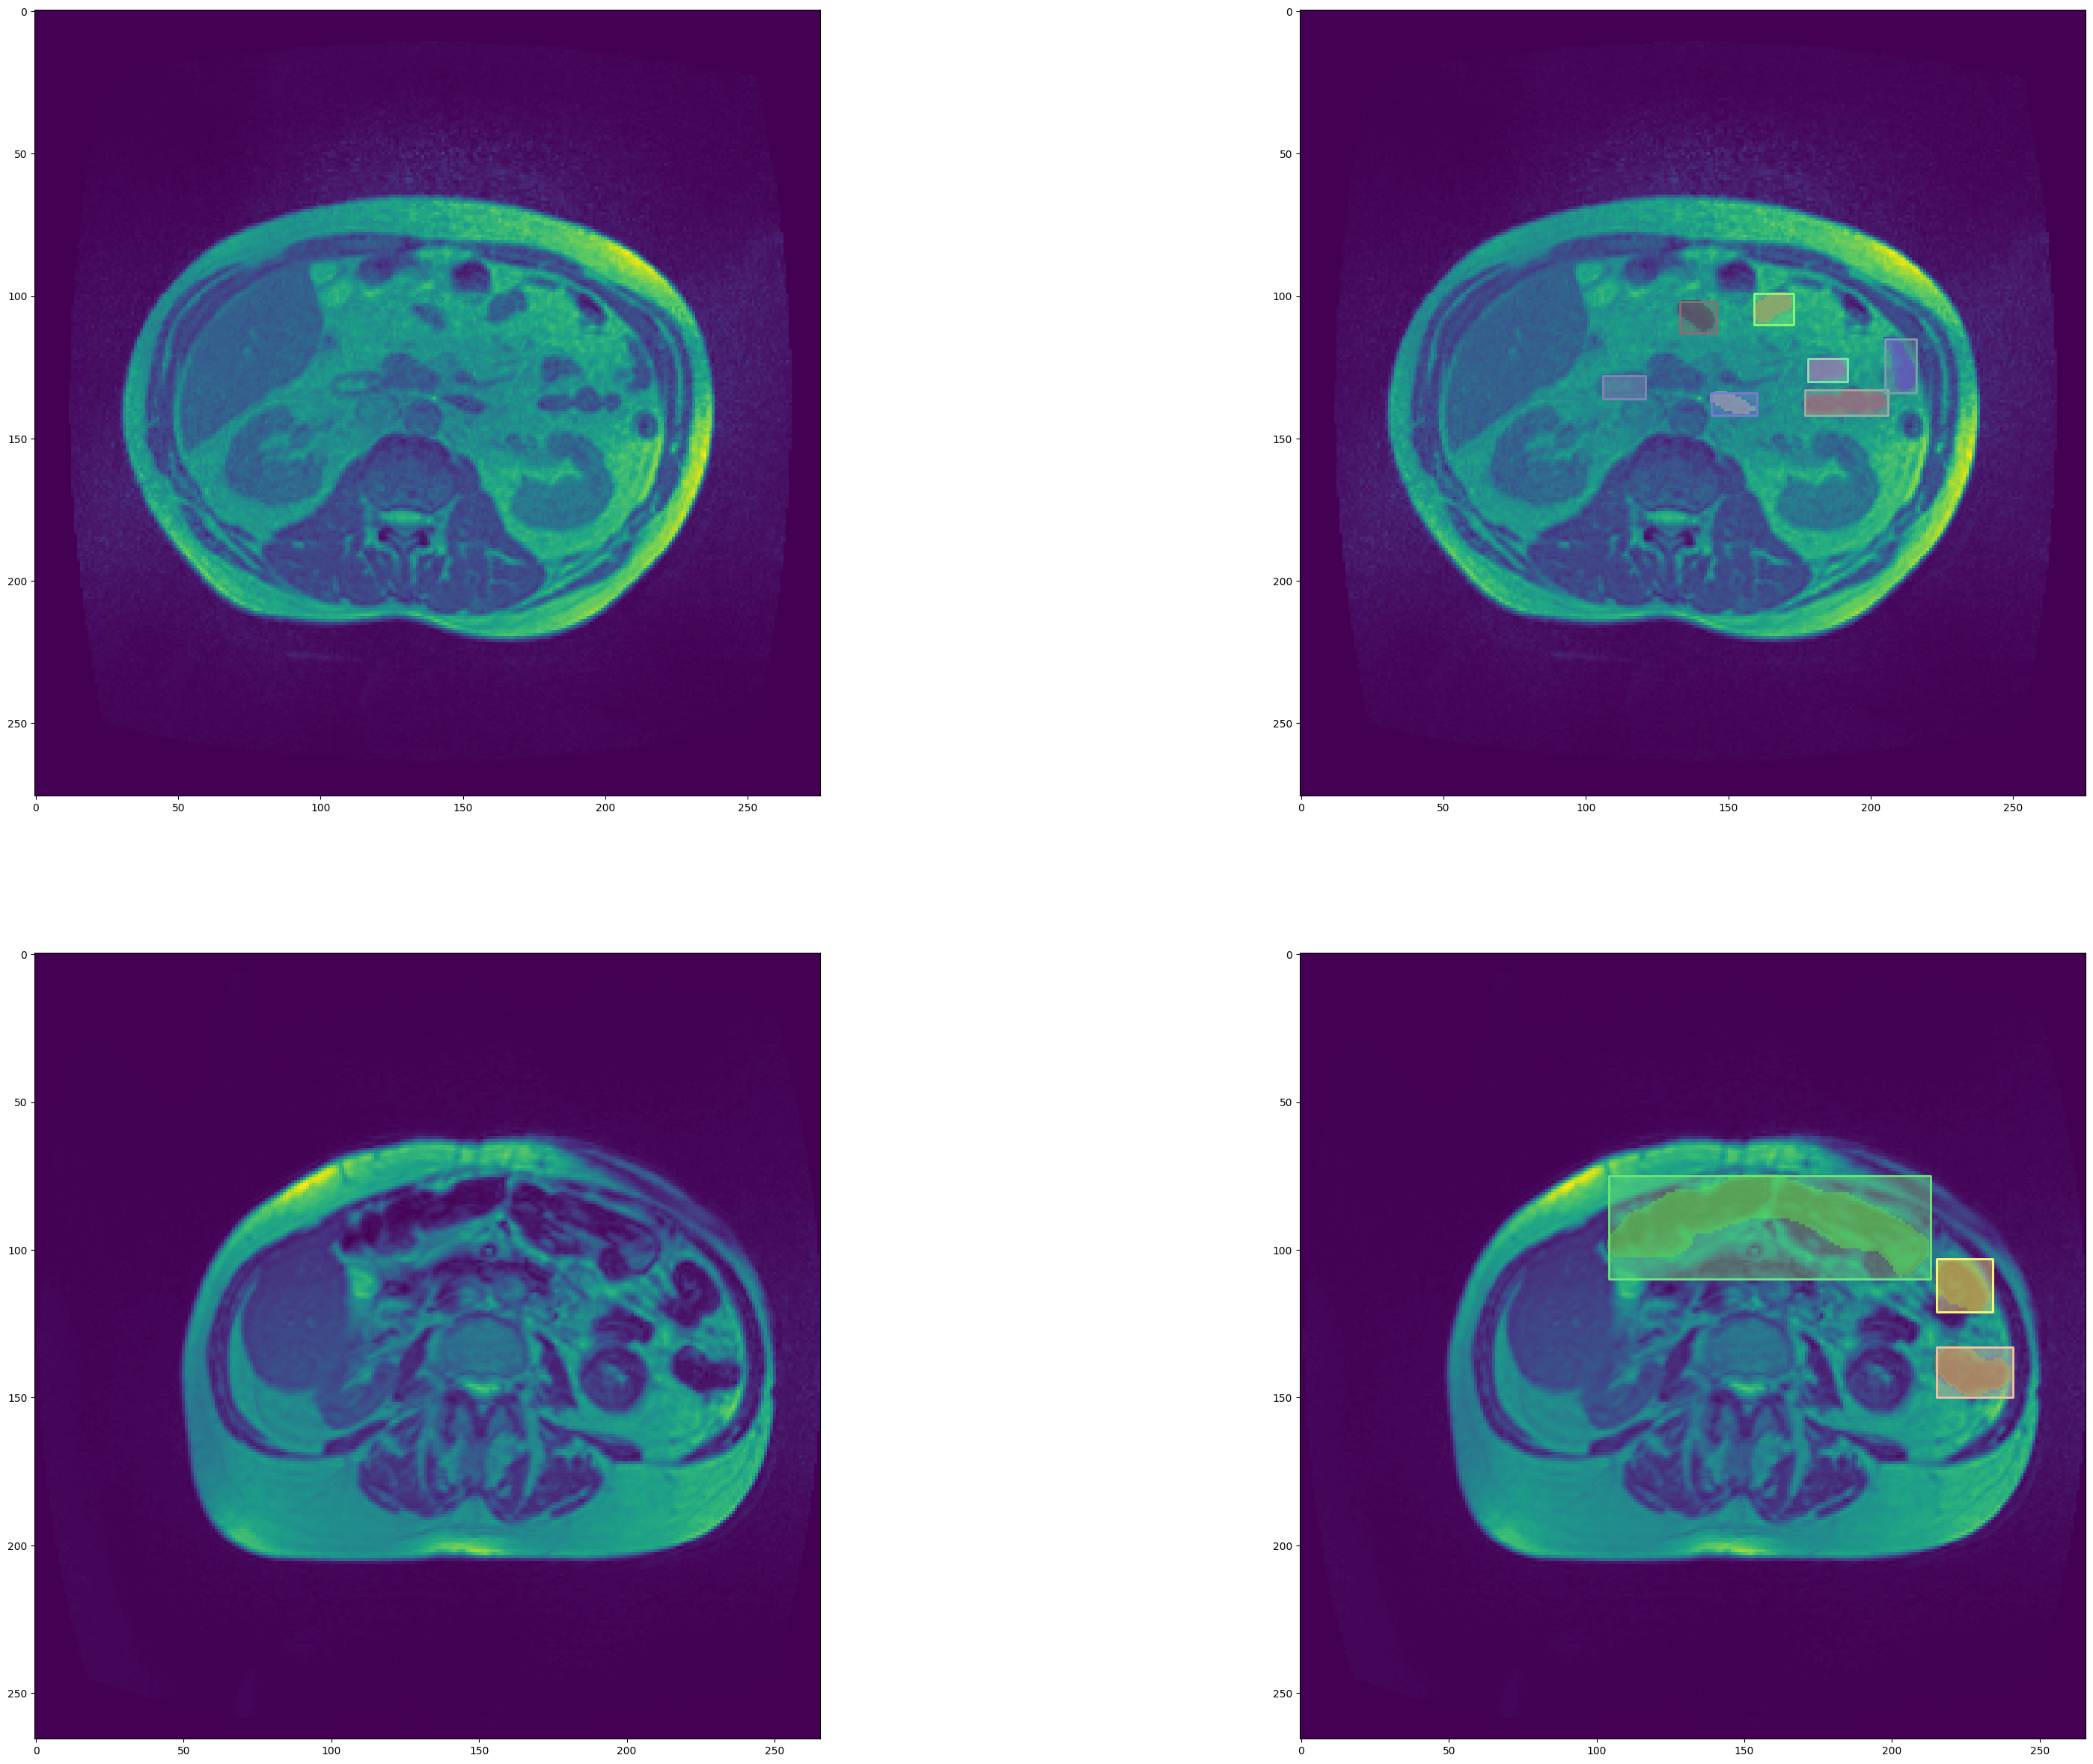

In [44]:
from pathlib import Path
annFile = Path(f'./tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:2])
_, axs = plt.subplots(len(imgs), 2, figsize=(40, 15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.fromarray(
        np.array(Image.open(os.path.join(project_base_dir, "train", img['file_name']))).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [45]:
indexes = test_df['id'].value_counts().sort_values(
    ascending=False).to_frame().iloc[:1000, :].index

In [46]:
tmp_df = test_df[test_df['id'].isin(indexes)].sample(16)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.sort_values(['composite_id']).sample(4)

,id,class,segmentation,case_number,day_number,slice_number,file_path,file_name,composite_id,image_height,image_width,resolution
9,case136_day27_slice_0084,large_bowel,43432 5 43790 8 44149 10 44508 12 44867 14 452...,136,27,0084,../uw-madison-gi-tract-image-segmentation/trai...,slice_0084_360_310_1.50_1.50.png,136_27_slice_0084_360_310_1.50_1.50.png,360,310,360x310
2,case139_day14_slice_0109,small_bowel,31293 2 31558 4 31824 5 32065 8 32089 7 32309 ...,139,14,0109,../uw-madison-gi-tract-image-segmentation/trai...,slice_0109_266_266_1.50_1.50.png,139_14_slice_0109_266_266_1.50_1.50.png,266,266,266x266
14,case89_day19_slice_0061,large_bowel,32625 9 32985 11 33345 12 33705 14 34065 16 34...,89,19,0061,../uw-madison-gi-tract-image-segmentation/trai...,slice_0061_360_310_1.50_1.50.png,89_19_slice_0061_360_310_1.50_1.50.png,360,310,360x310
1,case89_day20_slice_0079,large_bowel,17737 7 18001 15 18267 20 18533 22 18799 23 19...,89,20,0079,../uw-madison-gi-tract-image-segmentation/trai...,slice_0079_266_266_1.50_1.50.png,89_20_slice_0079_266_266_1.50_1.50.png,266,266,266x266


In [47]:
classes = ['small_bowel', 'large_bowel', 'stomach']
tmp_json = create_coco_format_json(tmp_df, classes, tmp_df['file_path'].tolist())

Generating annotations: 100%|███████████████████| 16/16 [00:00<00:00, 62.16it/s]


In [48]:
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()


with open('./tmp_json.json', 'w', encoding='utf-8') as f:
    json.dump(tmp_json, f, ensure_ascii=True, indent=4, default=np_encoder)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


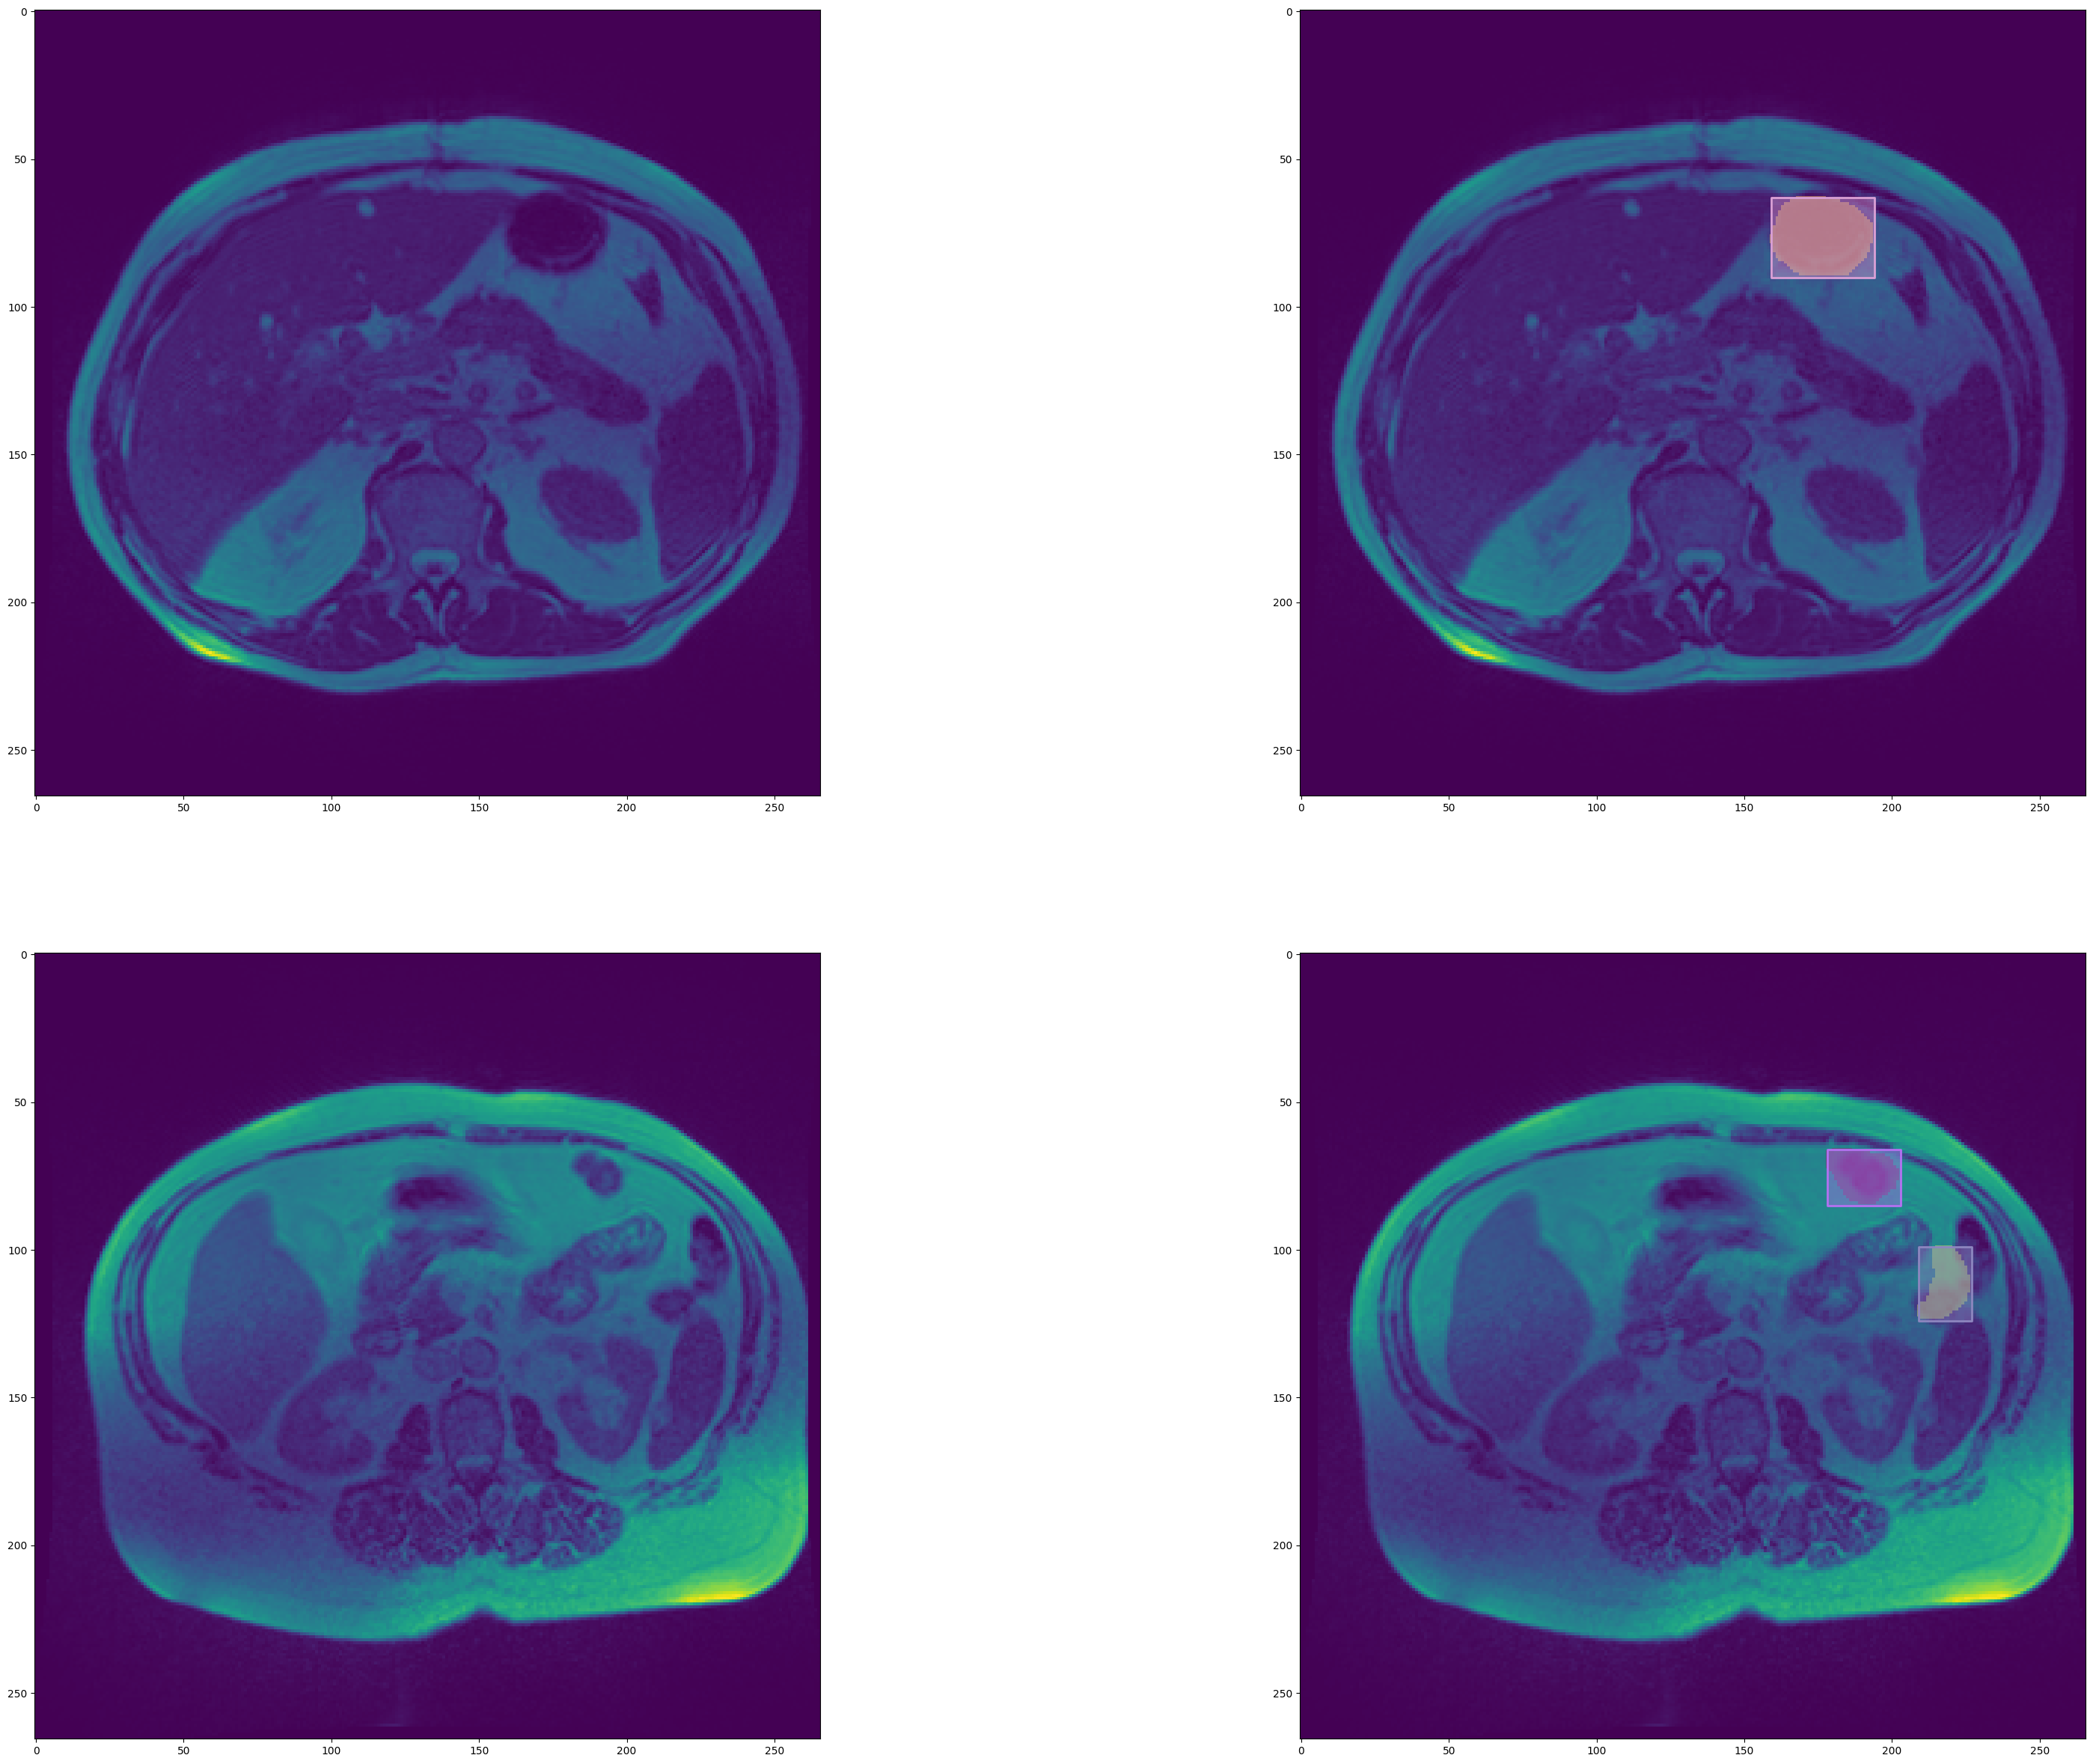

In [51]:
from pathlib import Path
annFile = Path(f'./tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:2])
_, axs = plt.subplots(len(imgs), 2, figsize=(40, 15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.fromarray(
        np.array(Image.open(os.path.join(project_base_dir, "train", img['file_name']))).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [52]:
train_df['file_path'][0]

'../uw-madison-gi-tract-image-segmentation/train/case2/case2_day4/scans/slice_0091_266_266_1.50_1.50.png'

In [53]:
classes = ['small_bowel', 'large_bowel', 'stomach']

train_json = create_coco_format_json(
    train_df, classes, train_df['file_path'].tolist())
test_json = create_coco_format_json(test_df, classes, test_df['file_path'].tolist())

Generating annotations: 100%|███████████████| 6783/6783 [02:39<00:00, 42.55it/s]


In [54]:
with open('train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)

with open('test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)


In [55]:
train_json = json.load(open('train_json.json', 'r'))
test_json = json.load(open('test_json.json', 'r'))

In [56]:
IMAGE_TRAIN_DIR = ''
ANNOTATION_FILE_VAL = (IMAGE_TRAIN_DIR+'test_json.json')
ANNOTATION_FILE_TRAIN = (IMAGE_TRAIN_DIR+'train_json.json')

coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds()
imgIds_train = coco_train.getImgIds()
imgDict_train = coco_train.loadImgs(imgIds_train)
print(len(imgIds_train), len(catIds_train))

coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val), len(catIds_val))

loading annotations into memory...
Done (t=1.80s)
creating index...
index created!
27130 3
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
6783 3


1
2
3
4


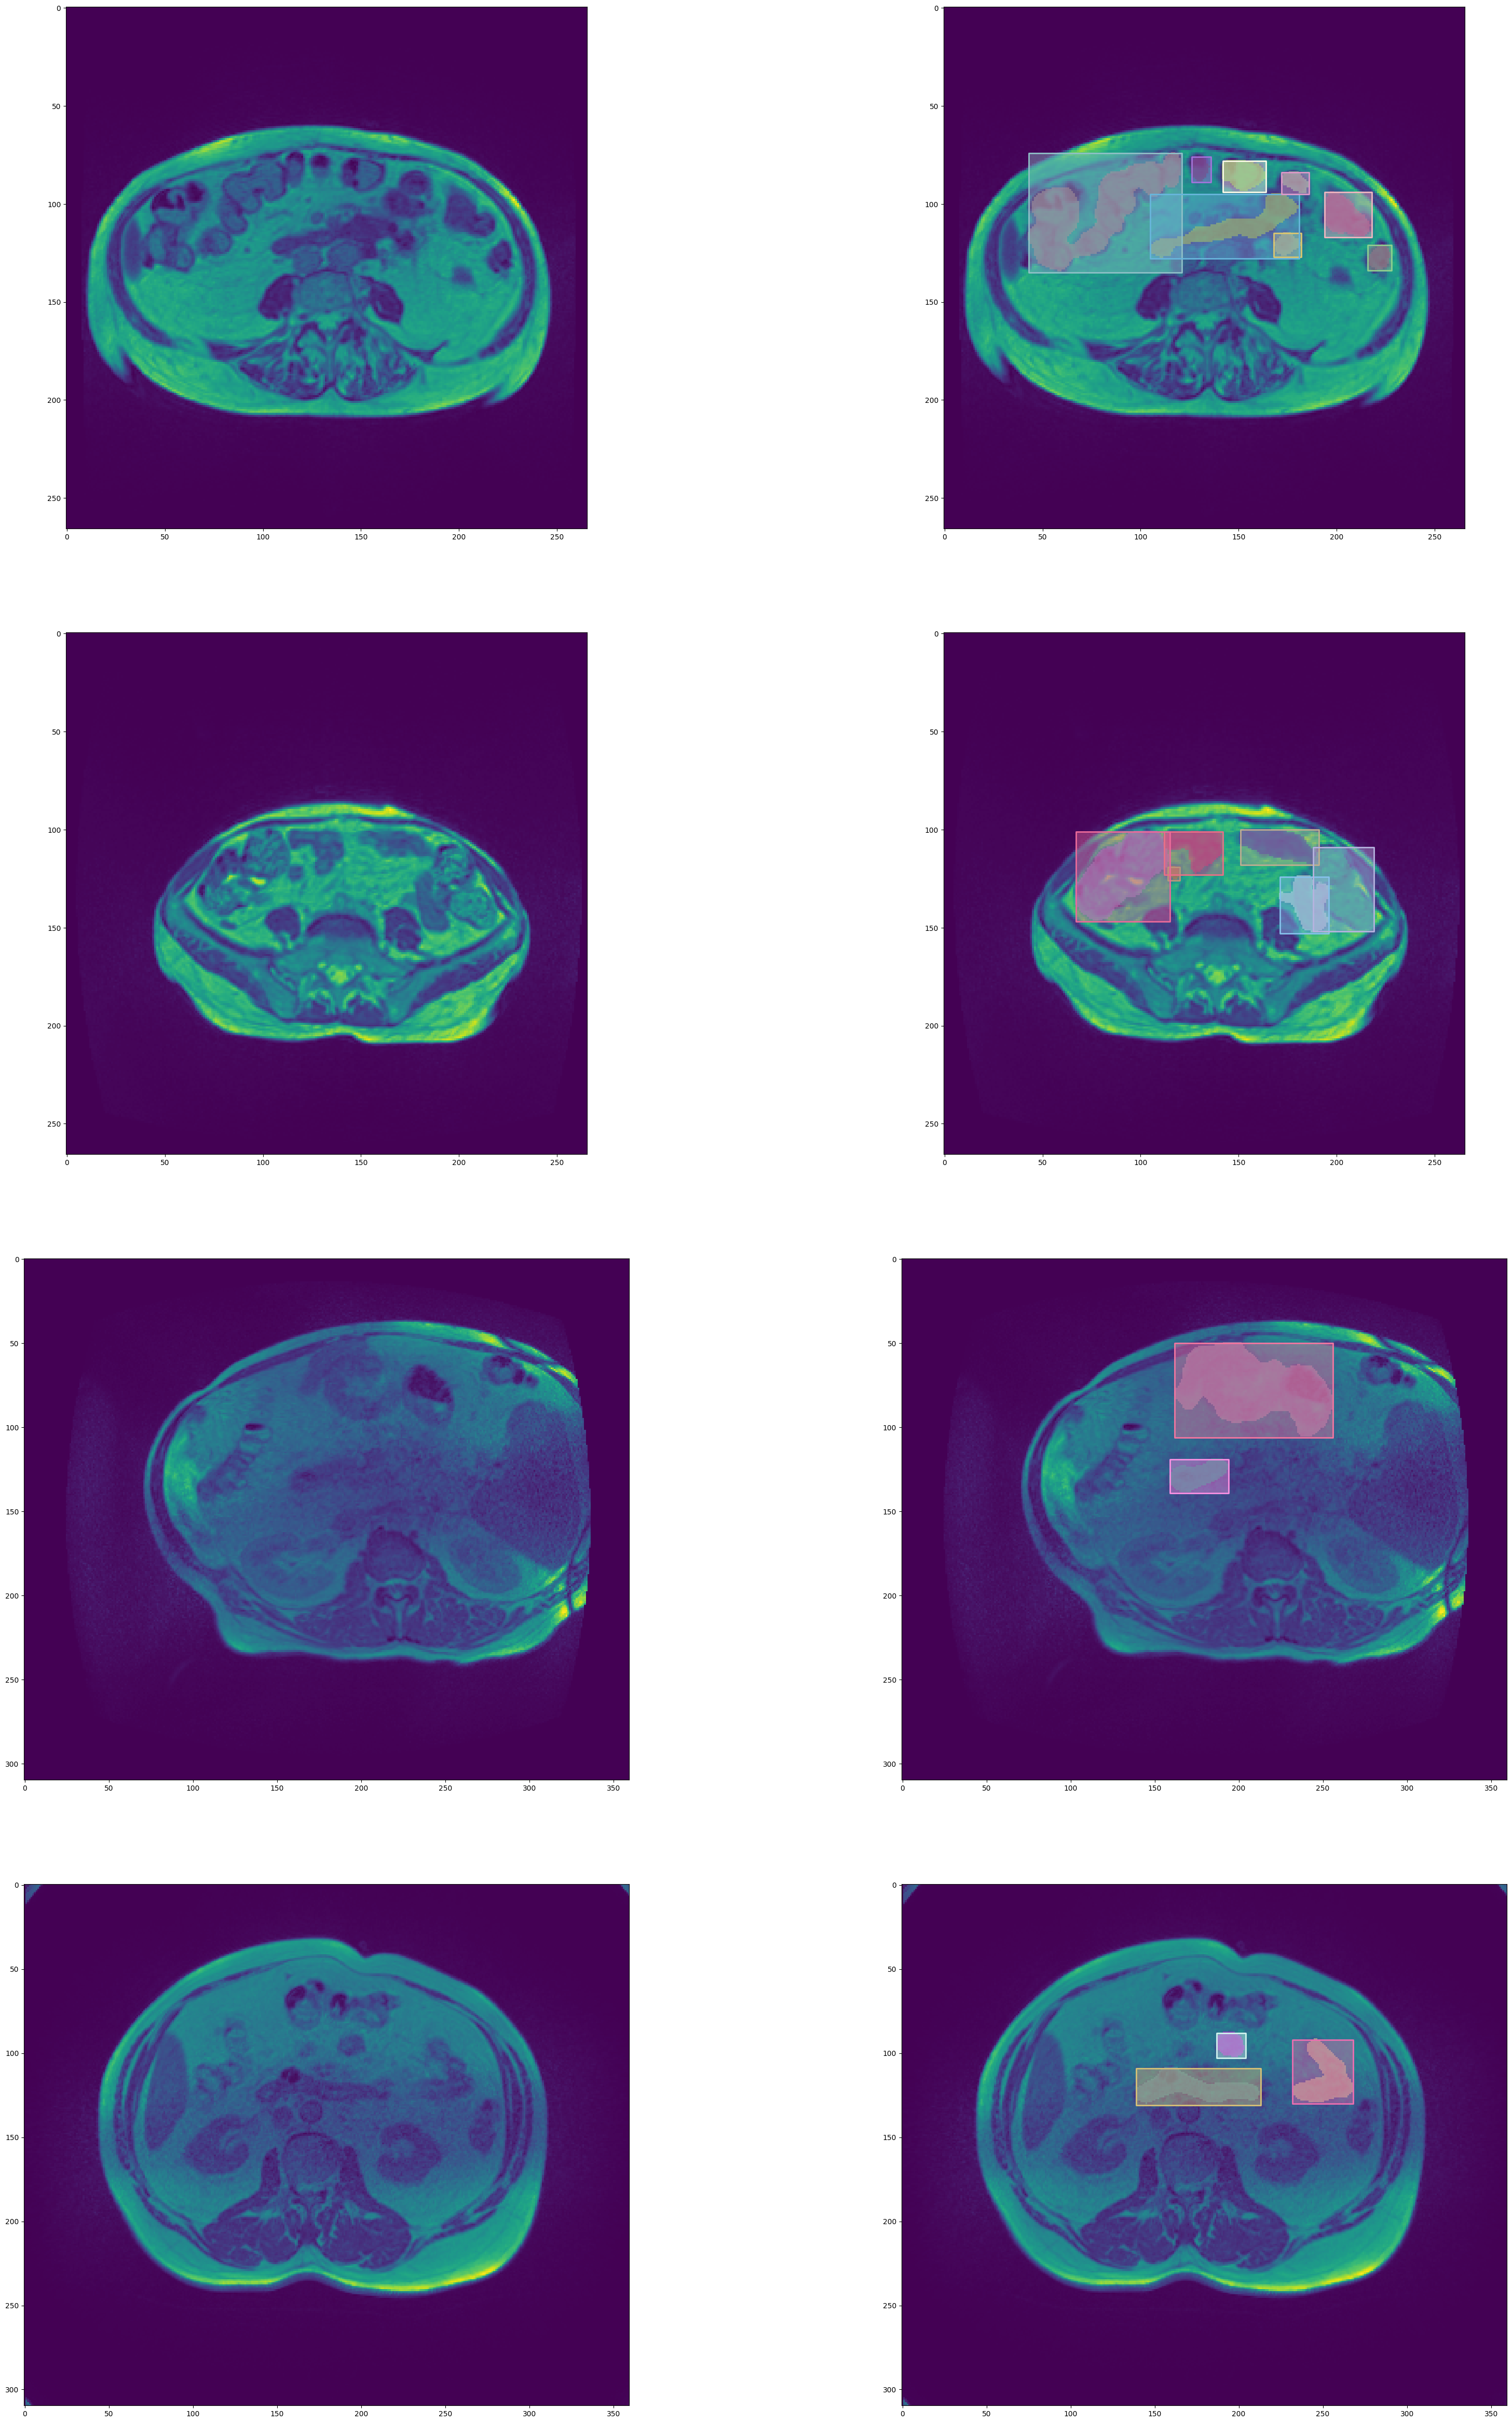

In [59]:
imgs = coco_train.loadImgs(imgIds_train[0:4])
_, axs = plt.subplots(len(imgs), 2, figsize=(40, 15 * len(imgs)))
for img, ax in zip(imgs, axs):
    print(img['id'])
    I = Image.open(os.path.join(project_base_dir, "train", img['file_name']))
    I = Image.fromarray(
        np.array(Image.open(os.path.join(project_base_dir, "train", img['file_name']))).astype("uint16"))
    annIds = coco_train.getAnnIds(imgIds=[img['id']])
    anns = coco_train.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco_train.showAnns(anns, draw_bbox=True)

In [60]:
classes = ['small_bowel', 'large_bowel', 'stomach']

images = []
if classes != None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco_train.getCatIds(catNms=className)
        imgIds = coco_train.getImgIds(catIds=catIds)
        images += coco_train.loadImgs(imgIds)
else:
    imgIds = coco_train.getImgIds()
    images = coco_train.loadImgs(imgIds)

# Now, filter out the repeated images
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 27130


In [61]:
unique_images[0]

{'id': 1,
 'file_name': 'case2/case2_day4/scans/slice_0091_266_266_1.50_1.50.png',
 'width': 266,
 'height': 266}

In [63]:
def filterDataset( classes=None, json_file=None):    
    # initialize COCO api for instance annotations
    annFile = json_file
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [98]:
classes = ['small_bowel', 'large_bowel', 'stomach']

images_tmp, dataset_size_tmp, coco = filterDataset( classes,  'tmp_json.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [68]:
classes = ['small_bowel', 'large_bowel', 'stomach']
images_train, dataset_size_train, coco_train = filterDataset( classes,  'train_json.json')
images_test, dataset_size_test, coco_val = filterDataset( classes,  'test_json.json')

loading annotations into memory...
Done (t=2.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [99]:
images_tmp[0]


{'id': 12,
 'file_name': 'case113/case113_day16/scans/slice_0083_360_310_1.50_1.50.png',
 'width': 360,
 'height': 310}

In [101]:
# display COCO categories and supercategories
annFile = Path(f'tmp_json.json')
coco = COCO(annFile)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
imgIds = coco.getImgIds()
imgDict = coco_train.loadImgs(imgIds)


classes = ['small_bowel', 'large_bowel', 'stomach']

images_tmp, dataset_size_tmp, coco = filterDataset(classes,  'tmp_json.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [107]:
coco.getImgIds()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [105]:
coco.getImgIds(catIds=catIDs)

[]

In [106]:
[img_id for img_id in coco.getImgIds(catIds=catIds) if coco.loadImgs(img_id)[0]['file_name'] in images_tmp]

[]

## Creating a data generator that takes a JSON file as a parameter, and constructs an image and 3 associated masks

In [71]:
batch_size = 8
input_image_size = (128,128)
mask_type = 'normal' 
classes = ['small_bowel', 'large_bowel', 'stomach']

In [143]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class DataGeneratorFromCocoJson(Dataset):
    def __init__(self, image_dir, annFile, subset="train", batch_size=32, image_list=[], 
                 classes=[], input_image_size=(128, 128), shuffle=False):
        self.image_dir = image_dir
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(image_list))
        self.image_list= image_list
        self.classes= classes
        self.input_image_size= (input_image_size)
        self.dataset_size = len(image_list)
        self.coco = COCO(annFile)
        catIds = self.coco.getCatIds(catNms=self.classes)
        self.catIds = catIds  
        self.cats = self.coco.loadCats(catIDs)
        self.imgIds = self.coco.getImgIds()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.imgIds) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.imgIds)

    def getClassName(self, classID, cats):
        for i in range(len(cats)):
            if cats[i]['id'] == classID:
                return cats[i]['name']
        return None


    def getNormalMask(self, image_id, catIds):
        annIds = self.coco.getAnnIds(image_id, catIds=catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)
        cats = self.coco.loadCats(catIds)
        train_mask = np.zeros(self.input_image_size,dtype=np.uint8)
        for a in range(len(anns)):
            className = self.getClassName(anns[a]['category_id'], cats)
            pixel_value = self.classes.index(className)+1
            new_mask = cv2.resize(self.coco.annToMask(anns[a])*pixel_value, self.input_image_size)
            train_mask = np.maximum(new_mask, train_mask)
        return train_mask          

    def getLevelsMask(self, image_id):
        #for each category , we get the x mask and add it to mask list
        res = []  
        mask = np.zeros((self.input_image_size))
        for j, category in enumerate(self.catIds):
            mask = self.getNormalMask(image_id, category)
            res.append(mask)
        return res       


    def getImage(self, file_path):
        train_img = cv2.imread(file_path, cv2.IMREAD_ANYDEPTH)
        train_img = cv2.resize(train_img, self.input_image_size)
        train_img = train_img.astype(np.float32) / 255.
        if (len(train_img.shape)==3 and train_img.shape[2]==3): 
            return train_img
        else: 
            stacked_img = np.stack((train_img,)*3, axis=-1)
            return stacked_img          

    def get_image_Infos_by_path_id(self, node):
        for dict in self.image_list:
            if dict['file_name'] == node:
                return dict


    def __getitem__(self, index):
        X = np.empty((self.batch_size, 128, 128, 3))
        y = np.empty((self.batch_size, 128, 128, 3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        for i in range(len(indexes)):
          value = indexes[i]
          img_info = self.image_list[value]
          w = img_info['height']
          h = img_info['width']
          X[i,] = self.getImage(img_info['file_name']) 
          mask_train = self.getLevelsMask(img_info['id'])
          for j in self.catIds:
            y[i,:,:,j] = mask_train[j]   

        X = np.array(X)
        y = np.array(y)

        if self.subset == 'train':
            return X, y
        else: 
            return X
            

In [144]:
# class DataGeneratorFromCocoJson(tf.keras.utils.Sequence):
#   # function getting info dataset from json coco
#   # Batch size
#   # subset train or test for annotations
#   # image_list to develop... 
#   # classes classe wanted
#   # input image size tuple (X,X)
#   # annFile path to annoted coco json file file 
#     def __init__(self, batch_size = batch_size, subset="train",image_list=[]
#                  ,classes=[], input_image_size=(128,128),annFile='',shuffle=False):
      
#         super().__init__()
#         self.subset = subset
#         self.batch_size = batch_size
#         self.indexes = np.arange(len(image_list))
#         self.image_list= image_list
#         self.classes= classes
#         self.input_image_size= (input_image_size)
#         self.dataset_size = len(image_list)
#         self.coco = COCO(annFile)
#         catIds = self.coco.getCatIds(catNms=self.classes)
#         self.catIds = catIds  
#         self.cats = self.coco.loadCats(catIDs)
#         self.imgIds = self.coco.getImgIds()
#         self.shuffle = shuffle
#         self.on_epoch_end()
  

#     def __len__(self):
#       return int(len(self.image_list)/self.batch_size)

#     def on_epoch_end(self):
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)      


#     def getClassName(self,classID, cats):
#         for i in range(len(cats)):
#             if cats[i]['id']==classID:
#                 return cats[i]['name']
#         return None
  
#     def getNormalMask(self,image_id,catIds):
#         annIds = self.coco.getAnnIds(image_id, catIds=catIds, iscrowd=None)
#         anns = self.coco.loadAnns(annIds)
#         cats = self.coco.loadCats(catIds)
#         train_mask = np.zeros(self.input_image_size,dtype=np.uint8)
#         for a in range(len(anns)):
#             className = self.getClassName(anns[a]['category_id'], cats)
#             pixel_value = self.classes.index(className)+1
#             new_mask = cv2.resize(self.coco.annToMask(anns[a])*pixel_value, self.input_image_size)
#             train_mask = np.maximum(new_mask, train_mask)
#             # train_mask = new_mask / 255.0
#         return train_mask          
        

#     def getLevelsMask(self,image_id):
#       #for each category , we get the x mask and add it to mask list
#       res = []  
#       mask = np.zeros((self.input_image_size))
#       for j,categorie in enumerate(self.catIds):
#         mask = self.getNormalMask(image_id,categorie)
#         res.append( mask)
#       return res       

#     def getImage(self,file_path):
#         train_img = cv2.imread(file_path, cv2.IMREAD_ANYDEPTH)
#         train_img = cv2.resize(train_img, (self.input_image_size))
#         train_img = train_img.astype(np.float32) / 255.
#         if (len(train_img.shape)==3 and train_img.shape[2]==3): 
#             return train_img
#         else: 
#             stacked_img = np.stack((train_img,)*3, axis=-1)
#             return stacked_img          

#     def get_image_Infos_by_path_id(self, node):
#         for dict in self.image_list:
#             if dict['file_name'] == node:
#                 return dict
            
    
#     def __getitem__(self, index):
#         X = np.empty((self.batch_size,128,128,3))
#         y = np.empty((self.batch_size,128,128,3))
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         for i in range(len(indexes)):
#           value = indexes[i]
#           img_info = self.image_list[value]
#           w = img_info['height']
#           h = img_info['width']
#           X[i,] = self.getImage(img_info['file_name']) 
#           mask_train = self.getLevelsMask(img_info['id'])
#           for j in self.catIds:
#             y[i,:,:,j] = mask_train[j]   

#         X = np.array(X)
#         y = np.array(y)

#         if self.subset == 'train':
#             return X, y
#         else: 
#             return X

In [145]:
annFile = Path(f'tmp_json.json')
coco = COCO(annFile)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
imgIds = coco.getImgIds()
imgDict = coco_train.loadImgs(imgIds)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [146]:
tmp_generator_class = DataGeneratorFromCocoJson(image_dir='../uw-madison-gi-tract-image-segmentation/train',
                                                annFile=annFile,
                                                subset="train",
                                                batch_size=batch_size, 
                                                image_list=images_tmp,
                                                classes=classes,
                                                input_image_size=(128,128),
                                                shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [147]:
len(images_tmp)

16

In [148]:
X, y = tmp_generator_class.__getitem__(1)

fig = plt.figure(figsize=(50, 40))
gs = gridspec.GridSpec(nrows=len(X), ncols=2)
colors = ['yellow','green','red']
labels = [ "Small Bowel","Large Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])
flag=False
for i in range(0,1):

    images, mask = X[i], y[i]
    sample_img=images/255.
    mask1=mask[:,:,0]
    mask2=mask[:,:,1]
    mask3=mask[:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img[:,:,0], cmap='gray')

    ax1 = fig.add_subplot(gs[i, 1])
    if(flag == False):
      flag= True
      ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
      ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
      plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img[:,:,0], cmap='gray')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
plt.subplots_adjust(left=0.11, bottom=0.08, right=0.3, top=0.92, wspace=0.01, hspace=0.08)

[ WARN:0@36133.500] global loadsave.cpp:248 findDecoder imread_('case123/case123_day0/scans/slice_0083_266_266_1.50_1.50.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [114]:
images, mask = X[i], y[i]
sample_img=images/255.

In [143]:
# display COCO categories and supercategories
annFile = Path(f'tmp_json.json')
coco = COCO(annFile)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
imgIds = coco.getImgIds()
imgDict = coco_train.loadImgs(imgIds)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [144]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]['name']
    return "None"
cats

[{'id': 0, 'name': 'small_bowel'},
 {'id': 1, 'name': 'large_bowel'},
 {'id': 2, 'name': 'stomach'}]

In [145]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses =  ['small_bowel', 'large_bowel', 'stomach']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco_train.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

ValueError: operands could not be broadcast together with shapes (310,360) (266,266) 

Unique pixel values in the mask are: [0. 1.]


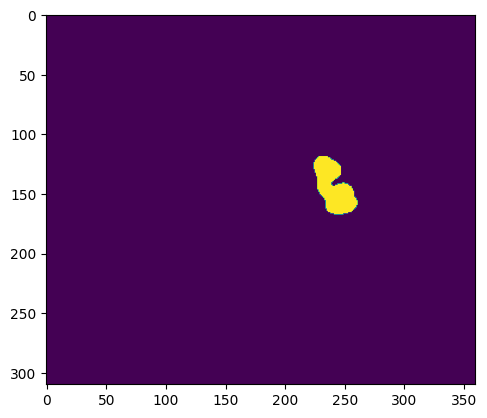

In [139]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco_train.annToMask(anns[i]), mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))